In [2]:
%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.inversion as inv 

from antarctic_plots import utils
import numpy as np
import pandas as pd
# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()
%load_ext snakeviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


#  Setup inversion and layers

region is 1000 x 1000 km
filtering and resampling ice from 1000m to 10000m
filtering and resampling water from 1000m to 10000m
filtering and resampling bathymetry from 1000m to 10000m
ice: 19600 points, elevations:3700m to 0m
water: 19600 points, elevations:3698m to -2866m
bathymetry: 19600 points, elevations:3698m to -4063m
gravity: 5220 points
gravity avg. elevation: 1000
bathymetry control points:10475932


,x,y,Gobs,z
0,-325000.0,-467500.0,-36.742543,1000.0
1,-315000.0,-467500.0,-34.715340,1000.0
2,-305000.0,-467500.0,-30.326696,1000.0
3,-295000.0,-467500.0,-27.588591,1000.0
4,-285000.0,-467500.0,-30.267524,1000.0
...,...,...,...,...
5215,245000.0,-1362500.0,-18.815760,1000.0
5216,255000.0,-1362500.0,-15.474126,1000.0
5217,265000.0,-1362500.0,-13.577327,1000.0
5218,275000.0,-1362500.0,-12.749213,1000.0


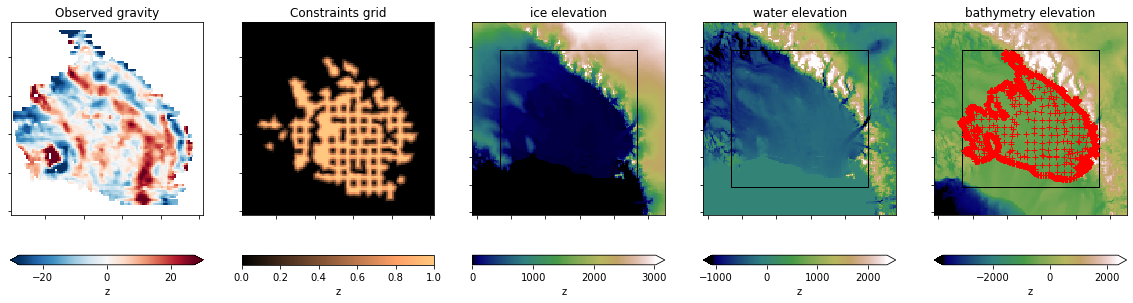

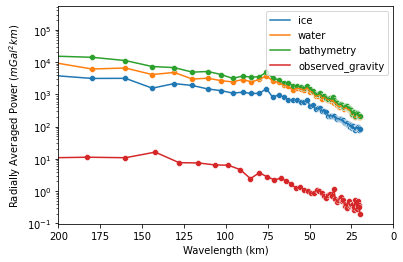

In [14]:
# starting inversion region is 1,000km x 1,000km, choose whether to zoom in, shift the 
# region to the North or West, or change the width of the buffer zone. 
inv_reg, buffer_reg, inv_proj = utils.alter_region(
    starting_region = [-580000, 420000, -1420000, -420000],
    zoom = 0,#350e3,
    n_shift = 0,
    w_shift = 0,#100e3,
    buffer = 200e3,
    )

returned = inv.import_layers(
    layers_list = [
        'ice',
        'water',
        'bathymetry',
        # 'basement',
        # 'moho',
        ], 
    spacing_list = [
        10e3,
        10e3,
        10e3,
        # 10e3,
        # 20e3,
        ], 
    rho_list = [
        920, #890 to 917 from Muto et al. 2013
        1030, #from Muto et al. 2013
        2300,
        # 2670,
        # 3300,
        ],
    fname_list = [
        # SURFACE 
            'inversion_layers/bedmachine/BedMachine_surface_filled.nc',
        # ICEBASE
            'inversion_layers/bedmachine/BedMachine_icebase_filled.nc',
        # BED/BATHYMETRY
            # 'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
            # 'bathymetry_data/bedmap2_bed_regional.nc',
            'inversion_layers/bedmachine/BedMachine_bed.nc',
        # BASEMENT
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            # 'inversion_layers/RE_basement_BedMachinebed_filled.nc',
            # 'inversion_layers/lindeque_basement.nc',
        # MOHO
            # 'inversion_layers/An_moho_filt.nc',
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc',
        ],
    grav_spacing = 10e3, 
    active_layer='bathymetry',
    buffer_region = buffer_reg,
    inversion_region = inv_reg,

    # Choose between grid and csv, similar comp. times
    # grav_file='gravity_data/rosetta_eq_source_up_continued_Gobs.nc',
    grav_file='gravity_data/rosetta_eq_source_up_continued.csv',
    # grav_file = 'gravity_data/ant4d_gravity_epsg_5k.nc',

    constraints=True,
    constraints_file='constraints_grid/constraints_grid.nc',
    constraints_points='bathymetry_data/bedmachine_RIGGS.csv',
    
    plot=True,
    plot_region=buffer_reg,
    power_spectrum=True,
    )
layers, grav, grav_spacing, constraints_grid, constraints_df, constraints_RIS_df = returned
grav

# Make prism layers

In [ ]:
inv.grids_to_prism_layers(
    layers, 
    plot=True, 
    # plot_region=inv_reg,
    plot_type='2D', 
    buffer_region = buffer_reg,
    inversion_region = inv_reg,
    ) 

# Forward gravity

In [ ]:
# use below calc at full grid extent, not just grav observation points
# grav = utils.make_grid(inv_reg, grav_spacing, 1000, "z")

df_forward = inv.forward_grav_layers(
    layers, 
    grav,  
    plot=True,
    grav_spacing=grav_spacing,
    inversion_region = inv_reg,
    # exclude_layers=['ice'],
    plot_dists=True,
    power_spectrum=True,
    )
df_forward.describe()

# Anomalies

In [ ]:
filter='g200e3'
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'filter', 
        filter=filter,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

In [ ]:
trend=4
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'trend', 
        trend=trend,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

In [ ]:
df_anomalies = inv.anomalies(
        layers, 
        df_forward, 
        grav_spacing, 
        'constraints', 
        constraints=constraints_df,
        constraints2plot=constraints_RIS_df,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

# Geo inversion

In [ ]:
# %%snakeviz --new-tab
regional_method='trend'

iter_corrections, df_inversion = inv.geo_inversion(
    active_layer='bathymetry',
    layers=layers, 
    input_grav=df_anomalies, 
    regional_method = regional_method,
    Max_Iterations=3,
    deriv_type='prisms',
    max_layer_change_per_iter=100,

    apply_constraints = False,
    constraints_grid=constraints_grid,
    exclude_layers=['ice'],

    # filter=filter, 
    trend=trend,
    # constraints=constraints_df,

    inversion_region = inv_reg,
    buffer_region=buffer_reg,
    grav_spacing = grav_spacing,
    ) 
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 5th trend,: 18m 3s
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 400km filter,: 19m 35s

# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, annulus, 3its, constraints off
# 200km filter. 200km buffer,: 14mins
# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from 200km filter. 200km buffer,: 2 mins

# 07/28/22, full size, just ROSETTA, 10km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from constraints. 200km buffer, mins
notify

In [ ]:
inv.plot_inversion_results(
    df_inversion,
    'bathymetry',
    grav_spacing,
    'epsg:3031',
    layers,
    iter_corrections,
    inversion_region = inv_reg,
    # plot_region = buffer_reg,
    plot_constraints = False,
    # constraints = constraints_RIS_df,
)

# Density inversion

In [ ]:
# density_inversion(
    # density_layer='bathymetry', 
    # plot=True
    # ) 
#10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify